In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train = pd.read_csv('./data/titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---

# Exploratory Analysis

## Missing data?
It appears a few rows from the **Cabin** column are missing. Sometimes we have missing data, and this can affect our models. So first we might like to create a heatmap to see where we are missing the majority of our data.

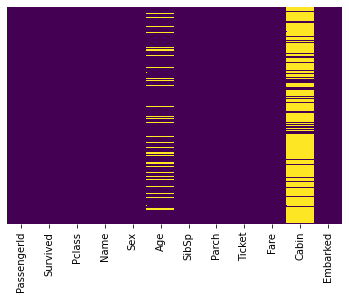

In [3]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

From here, we can see that we are missing some age information, but mostly we're missing a lot of cabin information. It may be necessary to drop that column.

However, we might have sufficient information regarding ages to try and reasonably estimate the missing ages.

## Explore Survived Column
Let's continue to explore this sample data to see how surviorship affects a few of the different columns.

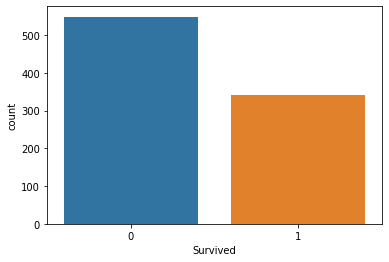

In [4]:
sns.countplot(x='Survived', data=train)

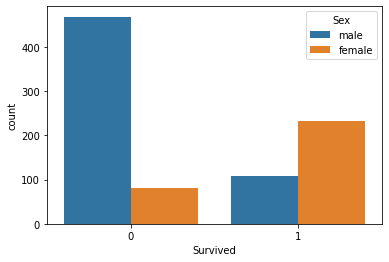

In [5]:
sns.countplot(x='Survived',hue='Sex',data=train)

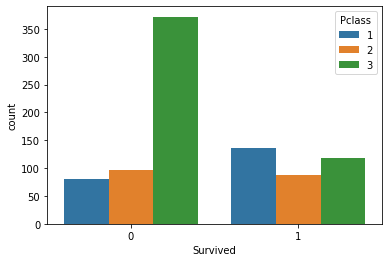

In [6]:
sns.countplot(x='Survived',hue='Pclass',data=train)

So it appears that an large percentage of deaths, $\text{Survived} = 0$, were from the lowest passenger class.

Additionally, of the numbers from the survivors group, the first class passenger class had the highest number of survivors.

## Explore Age Column
Let's paint a picture of the passengers to gain any additional insight.

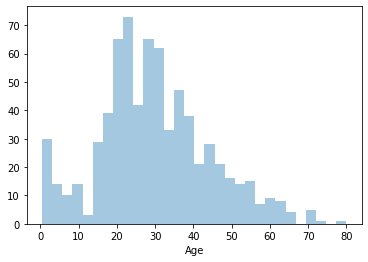

In [7]:
sns.distplot(train['Age'].dropna(), kde=False,bins=30)

This is a bimodal distribution. This suggests children $(<10)$ and young persons $(20 < \text{Age} < 40)$ are most represented by this sample.

## Explore SibSp column
This column contains the number of siblings/spouses onboard.

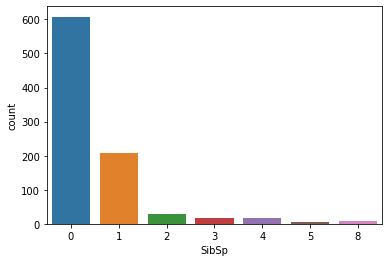

In [8]:
sns.countplot(x='SibSp', data=train)

We can assume that most passengers were single, or had only one spouse onboard.

## Explore Fare Column
Let's look at the distribution of fare paid for this voyage.

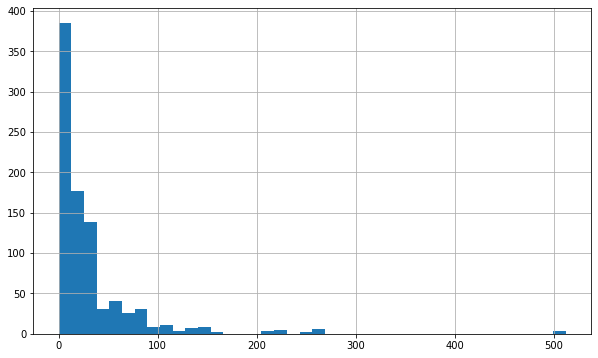

In [9]:
train['Fare'].hist(bins=40, figsize=(10,6))

---

# Cleaning the Train Data

## Missing Ages
We want to fill in missing data for missing ages, rather than dropping all the rows with missing ages.
One way to do this is to fill those with missing ages with the mean.

Additionally, we can be perhaps more accurate by filling in the missing age for the respective passenger class. So let's see how the **Ages** compare across the **Passenger Classes**

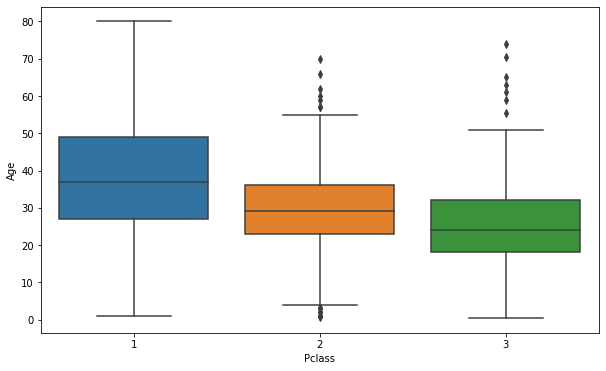

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Pclass', y='Age', data=train)
plt.show()

We see that the older one is, the more likely they were to have been able to afford the more expensive fares of the higher classes.

So let's write a function that fills in the missing data with these separate age averages.

In [11]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return train[train['Pclass']==1]['Age'].mean()
        elif Pclass == 2:
            return train[train['Pclass']==2]['Age'].mean()
        else:
            return train[train['Pclass']==3]['Age'].mean()
    else:
        return Age

In [12]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now we can double check to ensure we have no missing data for our **Age** column.

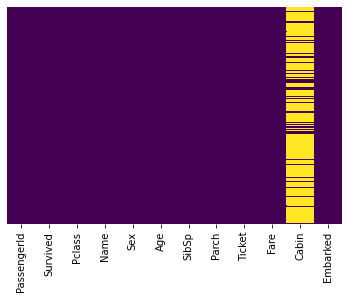

In [13]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Missing Cabin
There are simply too many missing datapoints to do anything useful with the cabin column. So rather than introduce potential noise, we can drop this column from our sample data.

In [14]:
train.drop('Cabin', axis=1, inplace=True)

Now can make sure the **column** for the Cabin information was dropped.

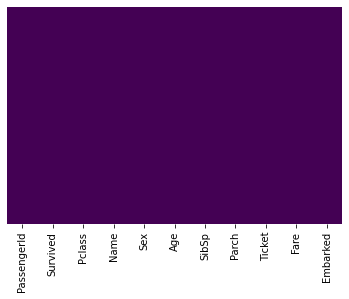

In [15]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Success!
We can see that all our missing data is now populated with some information.

## Categorical Features
The last cleansing we need to perform is replacing categorical features with some pre-assigned dummy variable.  
For example, with the **Sex** column we will need to replace *male* and *female*

\begin{align*}
x_i = \begin{cases} 1 & \text{if } i \text{th person is male,} \\
            0 & \text{if } i \text{th person is female} \end{cases}
\end{align*}

In [16]:
sex = pd.get_dummies(train['Sex'], drop_first=True)
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


**Note:** We need to avoid the issue of [Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity), which occurs when you have one predictor variable as a perfect predictor of another. To do this, we have to drop the column that identifies whether a passenger is female and leave only with whether a passenger is male. This results in the identical dummy variable ordering we arbitrarily defined above.

In [17]:
embark = pd.get_dummies(train['Embarked'], drop_first=True)
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [18]:
train = pd.concat([train,sex,embark],axis=1)
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1


Now we only need to drop the remaining columns we are not going to use.

In [19]:
train.drop(['Sex','Embarked','Name','Ticket', 'PassengerId'], axis=1, inplace=True)
train.head(3)

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1


**Note:**  The **Pclass** column is actually categorical, but since it isn't configured in the dataframe as a category, then it will likely be treated as a *continuous variable*. We will leave the column like this for now so we can observe the difference between the models when this column is treated as a continuous variable, vs a category.

---

# Model and Test the Data
First we will split our train data, since the Titanic *test* data isn't supervised with a **Survived** column.
Therefore, we will train and test with the Titanic *train* data so that we can later evaluate our model using the method from the course in the section below.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X = train.drop('Survived',axis=1)
y = train['Survived']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Now we can model this data.

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
logmodel = LogisticRegression(max_iter=1000)

In [25]:
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [26]:
predictions = logmodel.predict(X_test)

---

# Evaluate the Model
Scikit-learn has two options for a evaluating classification models.

The first is a human readable print-out of various parameters.  
The second is a python array with corresponding confusion matrix parameters.

In [27]:
from sklearn.metrics import classification_report

In [28]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       154
           1       0.80      0.68      0.73       114

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268



In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix(y_test,predictions)

array([[135,  19],
       [ 37,  77]])